In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

### Tools


In [2]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=3)]

In [3]:
from langchain_openai import ChatOpenAI

from langgraph.prebuilt import create_react_agent

# Choose the LLM that will drive the agent
llm = ChatOpenAI(model="gpt-4o-mini")
agent_executor = create_react_agent(llm, tools)

In [4]:
async def ask(question, config=None):
    async for chunk in agent_executor.astream(
        input={"messages": [("user", question)]}, stream_mode="values", config=config
    ):
        chunk["messages"][-1].pretty_print()

In [5]:
await ask("How's the weather today in Kyoto?")

================================ Human Message =================================

How's the weather today in Kyoto?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_XUv0VNzbJfEzgyJtDLDpZw8y)
 Call ID: call_XUv0VNzbJfEzgyJtDLDpZw8y
  Args:
    query: current weather in Kyoto
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.weatherapi.com/", "content": "{'location': {'name': 'Kyoto', 'region': 'Kyo\\x8dto', 'country': 'Japan', 'lat': 35.02, 'lon': 135.75, 'tz_id': 'Asia/Tokyo', 'localtime_epoch': 1723697231, 'localtime': '2024-08-15 13:47'}, 'current': {'last_updated_epoch': 1723697100, 'last_updated': '2024-08-15 13:45', 'temp_c': 35.8, 'temp_f': 96.4, 'is_day': 1, 'condition': {'text': 'Partly Cloudy', 'icon': '//cdn.weatherapi.com/weather/64x64/day/116.png', 'code': 1003}, 'wind_mph': 4.9, 'wind_kph': 7.9, 'wind_degree':

### State


In [6]:
import operator
from typing import Annotated, List, Tuple, TypedDict


class PlanExecute(TypedDict):
    input: str
    plan: List[str]
    past_steps: Annotated[List, operator.add]
    response: str

In [7]:
from langchain_core.pydantic_v1 import BaseModel, Field


class Plan(BaseModel):
    """Plan to follow in future"""

    steps: List[str] = Field(
        description="different steps to follow, should be in sorted order"
    )

In [8]:
from langchain_core.prompts import ChatPromptTemplate

planner_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.""",
        ),
        ("placeholder", "{messages}"),
    ]
)
planner = planner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Plan)

In [9]:
planner.invoke({"messages": [("user", "How old was the U.S. president in 1992?")]})

Plan(steps=['Identify the U.S. president in 1992.', 'Determine the birth year of that president.', 'Calculate the age of the president in 1992 by subtracting the birth year from 1992.'])

### Re-Plan Step


In [10]:
from typing import Union


class Response(BaseModel):
    """Response to user."""

    response: str


class Act(BaseModel):
    """Action to perform."""

    action: Union[Response, Plan] = Field(
        description="Action to perform. If you want to respond to user, use Response. "
        "If you need to further use tools to get the answer, use Plan."
    )


replanner_prompt = ChatPromptTemplate.from_template(
    """For the given objective, come up with a simple step by step plan. \
This plan should involve individual tasks, that if executed correctly will yield the correct answer. Do not add any superfluous steps. \
The result of the final step should be the final answer. Make sure that each step has all the information needed - do not skip steps.

Your objective was this:
{input}

Your original plan was this:
{plan}

You have currently done the follow steps:
{past_steps}

Update your plan accordingly. If no more steps are needed and you can return to the user, then respond with that. Otherwise, fill out the plan. Only add steps to the plan that still NEED to be done. Do not return previously done steps as part of the plan."""
)


replanner = replanner_prompt | ChatOpenAI(
    model="gpt-4o-mini", temperature=0
).with_structured_output(Act)

### Create the Graph


In [11]:
from typing import Literal


async def execute_step(state: PlanExecute):
    plan = state["plan"]

    # if not plan:
    #     # No plan was generated
    #     output = await replanner.ainvoke(state)
    #     return {"response": output.action.response}

    plan_str = "\n".join(f"{i+1}. {step}" for i, step in enumerate(plan))
    task = plan[0]
    task_formatted = f"""For the following plan:
{plan_str}\n\nYou are tasked with executing step {1}, {task}."""
    agent_response = await agent_executor.ainvoke(
        {"messages": [("user", task_formatted)]}
    )
    return {
        "past_steps": [task, agent_response["messages"][-1].content],
    }


async def plan_step(state: PlanExecute):
    plan = await planner.ainvoke({"messages": [("user", state["input"])]})
    return {"plan": plan.steps}


async def replan_step(state: PlanExecute):
    output = await replanner.ainvoke(state)
    if isinstance(output.action, Response):
        return {"response": output.action.response}
    else:
        return {"plan": output.action.steps}


def should_end(state: PlanExecute) -> Literal["agent", "__end__"]:
    if "response" in state and state["response"]:
        return "__end__"
    else:
        return "agent"

In [12]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(PlanExecute)

# Add the plan node
workflow.add_node("planner", plan_step)

# Add the execution step
workflow.add_node("agent", execute_step)

# Add a replan node
workflow.add_node("replan", replan_step)

workflow.add_edge(START, "planner")

# From plan we go to agent
workflow.add_edge("planner", "agent")

# From agent, we replan
workflow.add_edge("agent", "replan")

workflow.add_conditional_edges(
    "replan",
    # Next, we pass in the function that will determine which node is called next.
    should_end,
)

app = workflow.compile()

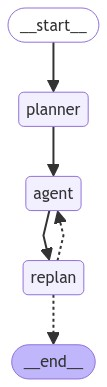

In [13]:
from IPython.display import Image, display

display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [14]:
from langchain_core.prompts import PromptTemplate
from datetime import datetime

config = {"recursion_limit": 50}
question = f"Today is {datetime.now()}. How old is the champion of the 200 meters at the 2024 Olympics"

In [15]:
await ask(question)

================================ Human Message =================================

Today is 2024-08-15 12:48:55.468966. How old is the champion of the 200 meters at the 2024 Olympics
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_Ms9HAf3h7PEQZDyN1OfnpZZI)
 Call ID: call_Ms9HAf3h7PEQZDyN1OfnpZZI
  Args:
    query: 2024 Olympics 200 meters champion age
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.latimes.com/sports/olympics/story/2024-08-06/harvard-grad-gabby-thomas-sprints-to-200-meter-gold-medal-for-the-united-states", "content": "SAINT-DENIS, France \u2014 Gabby Thomas sped to the victory in the women's 200 meters at the 2024 Olympics on Tuesday night, finishing in 21.83 seconds to add a gold to the bronze she took home in ..."}, {"url": "https://www.reuters.com/sports/olympics/athletics-botswanas-tebogo-wins-mens-2